# Custom Time Evolution

GRANAD lets you customize the Master Equation you simulate and extract any information from it.

*Note*: Please consult the tutorial on potentials first.

*Note*: While a bit more complicated, this tutorial can help you make your simulations not only more versatile, but also increase their efficiency.

## Hamiltonian

When calling the integration for the master equation, you can give an optional argument, `hamiltonian`. As already discussed, this argument represents a Hamiltonian as a dictionary of functions.

Up to now, we  wanted to use custom potentials, so we  added them to the dictionary. Let's look more closely at what is going on by considering a flake under plane wave illumination.

In [1]:
from granad import MaterialCatalog, Triangle, Wave
flake = MaterialCatalog.get( "graphene" ).cut_flake( Triangle(15)  )
wave = Wave( amplitudes = [1.0, 0., 0.], frequency = 1.0 )
hamiltonian_model = flake.get_hamiltonian(illumination = wave)
print(hamiltonian_model.keys())

dict_keys(['bare_hamiltonian', 'coulomb', 'potential'])


As discussed, the default Hamiltonian  has three terms:

1. a bare hamiltonian.
2. an induced coulomb interaction.
3. an external potential.

Each of these terms is represented by a function. Every function accepts the following three arguments:

1. time
2. the density matrix at this time
3. an argument object `args`. It contains all required "static" information, like relaxation rates, energies or operators in the Schrödinger picture.

Every function maps these arguments to a complex matrix. Before running a simulation, the functions in the dictionary get turned into a list `func_list`. 

The matrix representation of the Hamiltonian is then given by applying and adding these functions, like so `H[time] = sum( f(times[time], density_matrix[time], args) for f in func_list )`.

## Argument Objects

The `args` object is a named tuple (like a struct in the C programming language) and we can inspect its contents by looking at its fields 

In [2]:
args = flake.get_args()
print(args._fields)

('hamiltonian', 'energies', 'coulomb_scaled', 'initial_density_matrix', 'stationary_density_matrix', 'eigenvectors', 'dipole_operator', 'electrons', 'relaxation_rate', 'propagator', 'spin_degeneracy', 'positions')


We can access individual entries

In [3]:
print(args.dipole_operator.shape)

(3, 46, 46)


The `args` object is a lower-level representation of the OrbitalList object: a collection of numbers and arrays that represent the structure.

The evolution is determined by the Hamiltonian. It is given by an addition of functions. Each of these functions depends on time, the density matrix and the simulated structure. So, a single function representing a term in the Hamiltonian has the following signature `term: time, density_matrix, args -> matrix`.

## Computing Terms

Individual terms of the default Hamiltonian can be inspected and since these are functions, applied to arguments. First, consider the bare Hamiltonian

In [4]:
import jax.numpy as jnp
h_bare = hamiltonian_model["bare_hamiltonian"]
time = 0.0
jnp.all(flake.hamiltonian == h_bare( time, args.initial_density_matrix, args ))

Array(True, dtype=bool)

The function returns the bare Hamiltonian, independent of the time and density matrix. Let's compute the Coulomb potential at the initial time

In [5]:
coulomb = hamiltonian_model["coulomb"]
coulomb_matrix = coulomb( time, args.initial_density_matrix, args ) 
jnp.all( coulomb_matrix == 0.0 )

Array(True, dtype=bool)

At the start of the simulation, there is no induced Coulomb potential (all entries in the matrix are zero), because the system is in its ground state.

Last, there is the external potential. Since no transition dipole moments are considered, it will be entirely diagonal in site basis

In [6]:
potential = hamiltonian_model["potential"]
potential_matrix = potential( time, args.initial_density_matrix, args )
jnp.all( potential_matrix == jnp.diag(potential_matrix.diagonal()) )

Array(True, dtype=bool)

## Modelling Terms

To include arbitrary terms in the time evolution, we define a function that

1. Accepts `time, density_matrix, args`
2. Returns a NxN complex matrix
3. Additionally, the function must be JAX-JIT compatible. In essence, only Python and jax.numpy operations must be used.

Then, we insert it in the dictionary, potentially overwriting a default key.

Let's illustrate this at the example of a custom scalar potential. We want to replace the dipole-gauge coupling $\vec{E} \vec{P}$ with a scalar potential representing a plane-wave pulse. Let's define this potential first

In [7]:
amplitudes = jnp.array([1e-5, 0, 0])
omega = 2*jnp.pi
sigma = 1
t0 = 4
def pulsed_potential( time, density_matrix, args ):
    field = (amplitudes * jnp.cos(omega * time) * jnp.exp( -(time-t0)**2 / sigma**2 ) )
    diagonal_part = args.positions @ field
    return jnp.diag( diagonal_part )

Now, we replace the default potential with our custom term,  as we did before in the case of the pulsed dipole.

In [8]:
hamiltonian_model["potential"] = pulsed_potential

To run a time-domain simulation, we  pass the modified Hamiltonian dictionary directly, as demonstrated in the first section

RHS compiled
RHS compiled


100.0 %


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


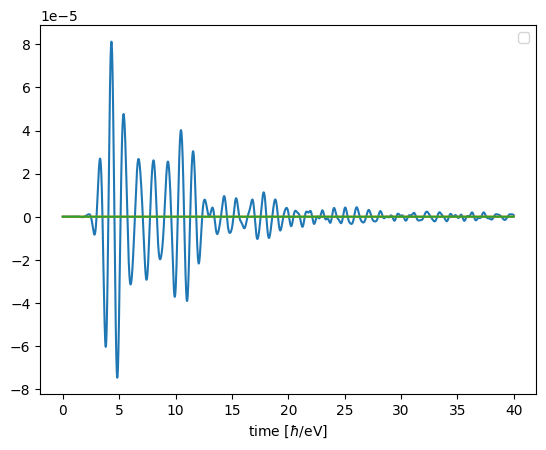

In [9]:
result = flake.master_equation( hamiltonian = hamiltonian_model, expectation_values = [flake.dipole_operator], relaxation_rate = 1/10, end_time = 40)
flake.show_res( result )

## Modelling Dissipators

Dissipators are modelled as functions with the same signature as terms in the Hamiltonian, i.e. to model a custom dissipator

1. Define a function `diss : time, density_matrix, args -> jax.Array`
2. put it in a dictionary `dissipator_model["diss"] = diss`
3. Pass `dissipator = dissipator_model` to the integrator function. 

You can also get defaults

In [10]:
dissipator_model = flake.get_dissipator(relaxation_rate = 1/10)
print( dissipator_model )

{'decoherence_time': <function DecoherenceTime.<locals>.<lambda> at 0x7f59a01bf560>}


NOTE: To pass the dissipator above to the `master_equation` method, you have to specify the relaxation rate again. 

## Postprocesses

You can define custom postprocesses. These are functions with the signature `postprocess : density_matrix_batch, args -> array`. The `density_matrix_batch` is an array of shape `TxNxN`, where `T` encodes time.

For example, if you are only interested in the occupation of the 0-th state

In [11]:
def extract_element(density_matrices, args):
    return density_matrices[:,0,0]

In [12]:
result = flake.master_equation( postprocesses = {"element" : extract_element},  relaxation_rate = 1/10, end_time = 40 )
print(result.output[0].shape)

RHS compiled
RHS compiled


100.0 %
(4000,)
